<a href="https://colab.research.google.com/github/ShaswatMi/Keystrokesmodel/blob/main/Keystrokemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Colab keystroke dynamics classifier (LSTM / 1D-CNN)
# Run this whole block in Google Colab.

# 1) Setup: imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from google.colab import output
import time
import json
import math
import matplotlib.pyplot as plt

# Global collector for events (populated by JS -> python callback)
KE_EVENTS = []  # list of dicts: {'t':ms, 'type':'down'/'up', 'key':..., 'masked':True/False}

# 2) Register callback to receive keystrokes from JS in the notebook frontend
def receive_keystrokes(events_json):
    # This function will be called from the browser JS
    try:
        # events_json comes as Python object already because invokeFunction will pass it
        # but sometimes it becomes a JSON string; handle both
        if isinstance(events_json, str):
            events = json.loads(events_json)
        else:
            events = events_json
        # Normalize times to epoch ms using time.time() baseline if needed
        # We'll store raw performance.now values directly; relative times are enough.
        for e in events:
            # safety: only store minimal info (mask characters by default)
            # If you want keys, set 'mask_keys' to False in the JS snippet below
            KE_EVENTS.append(e)
        print(f"Received {len(events)} events. Total stored events: {len(KE_EVENTS)}")
    except Exception as ex:
        print("Error in receive_keystrokes:", ex)

output.register_callback('notebook.receive_keystrokes', receive_keystrokes)

# 3) Display JS UI to capture keystrokes (runs in the browser)
from IPython.display import display, HTML, Javascript

display(HTML('''
<div>
  <p>Type in the box below to record keystrokes for this session. By default characters are <b>masked</b> (only timing + key category kept).</p>
  <textarea id="typingArea" placeholder="Start typing here..." rows=6 cols=80 style="font-size:14px"></textarea><br>
  <button id="sendBtn">Send recorded events to Python</button>
  <button id="clearBtn">Clear stored browser events</button>
  <label><input id="maskKeys" type="checkbox" checked> Mask actual characters (recommended)</label>
</div>
<script>
(function(){
  const text = document.getElementById('typingArea');
  const send = document.getElementById('sendBtn');
  const clear = document.getElementById('clearBtn');
  const maskCheckbox = document.getElementById('maskKeys');
  window._colab_ke_events = [];

  // Use performance.now() for high-res timestamps
  function pushEvent(e, type) {
    const ev = {
      t: performance.now(),
      type: type, // 'down' or 'up'
      key: maskCheckbox.checked ? (e.key === 'Backspace' ? 'Backspace' : 'KEY') : e.key
    };
    window._colab_ke_events.push(ev);
  }

  text.addEventListener('keydown', e => pushEvent(e, 'down'));
  text.addEventListener('keyup', e => pushEvent(e, 'up'));

  send.addEventListener('click', async () => {
    // call python callback with events array; then clear local buffer
    try {
      const toSend = window._colab_ke_events.slice();
      // google.colab.kernel.invokeFunction(name, args, kwargs)
      await google.colab.kernel.invokeFunction('notebook.receive_keystrokes', [toSend], {});
      window._colab_ke_events = [];
    } catch(err) {
      console.error('Error sending events to Python:', err);
      alert('Error sending events to Python (check console).');
    }
  });

  clear.addEventListener('click', () => {
    window._colab_ke_events = [];
    alert('Local browser events cleared.');
  });

})();
</script>
'''))

# 4) Preprocessing utilities
def events_to_pairs(events):
    # convert list of down/up events into list of keystrokes with timestamps
    # returns list of tuples (down_time, up_time, key)
    downs = {}
    strokes = []
    for e in events:
        t = e['t']
        typ = e['type']
        key = e.get('key','KEY')
        if typ == 'down':
            # keep last down for a key
            downs[key] = t
        elif typ == 'up':
            down_t = downs.pop(key, None)
            if down_t is not None:
                strokes.append({'down': down_t, 'up': t, 'key': key})
            else:
                # up without down: ignore or use up as a down fallback
                strokes.append({'down': t, 'up': t, 'key': key})
    # sort by down time
    strokes.sort(key=lambda s: s['down'])
    return strokes

def compute_features_from_strokes(strokes):
    # strokes: list of {'down','up','key'}
    # produce arrays: inter_key_intervals (down-to-down), hold_times (up-down), backspace flag
    downs = [s['down'] for s in strokes]
    ups = [s['up'] for s in strokes]
    keys = [s['key'] for s in strokes]
    if not downs:
        return None
    # inter-key intervals in ms
    ikis = [np.nan] * len(downs)
    ikis[0] = 0.0
    for i in range(1,len(downs)):
        ikis[i] = downs[i] - downs[i-1]
    # hold times
    holds = [ups[i] - downs[i] for i in range(len(downs))]
    # backspace indicator per stroke
    backspaces = [1.0 if (k == 'Backspace') else 0.0 for k in keys]
    # timestamps relative to first event
    t0 = downs[0]
    rel_time = [(d - t0)/1000.0 for d in downs]  # seconds
    df = pd.DataFrame({
        't': rel_time,
        'iki': ikis,
        'hold': holds,
        'backspace': backspaces
    })
    return df

def sliding_windows_from_df(df, window_size_seconds=5.0, step_seconds=1.0, min_events=5):
    # produce windows (for each window ending at time t): features aggregated as sequence
    # Here we will produce sequences on per-keystroke basis: take last N timesteps by time
    # Alternative: resample at fixed time resolution. Simpler: take last K keystrokes within window.
    windows = []
    times = df['t'].values
    end = times[-1]
    starts = np.arange(0, end, step_seconds)
    for s in starts:
        e = s + window_size_seconds
        mask = (df['t'] >= s) & (df['t'] < e)
        seg = df[mask]
        if len(seg) >= min_events:
            windows.append(seg.reset_index(drop=True))
    return windows

# Helper to convert variable-length window DataFrame to fixed-length sequence feature vector
def df_to_sequence(df, seq_len=128):
    # Build a 2D array shape (seq_len, features) using last seq_len keystrokes (pad with zeros)
    # features: [iki, hold, backspace]
    arr = np.zeros((seq_len, 3), dtype=np.float32)
    n = min(len(df), seq_len)
    sub = df.iloc[-n:]
    # normalize features: we'll use simple scalings (ms -> seconds)
    iki = np.array(sub['iki'].fillna(0.0))/1000.0
    hold = np.array(sub['hold'].fillna(0.0))/1000.0
    back = np.array(sub['backspace'].fillna(0.0))
    # place at end
    arr[-n:,0] = iki
    arr[-n:,1] = hold
    arr[-n:,2] = back
    return arr

# 5) Synthetic data generator (bootstrap labels)
def simulate_typing_sequence(num_keystrokes=200, human=True, seed=None):
    # returns pandas DataFrame like compute_features_from_strokes
    rng = np.random.RandomState(seed)
    if human:
        # human: mean interval ~ 150-250 ms, bigger sigma, some backspaces, varied hold times
        mean = rng.uniform(130,220)
        sigma = rng.uniform(60,130)
        back_prob = 0.03  # backspace rate
        hold_mean = rng.uniform(60,120)
        hold_sigma = rng.uniform(20,60)
    else:
        # AI-like: faster, more stable, almost no backspaces, very low variance
        mean = rng.uniform(50,120)
        sigma = rng.uniform(5,25)
        back_prob = 0.002
        hold_mean = rng.uniform(20,50)
        hold_sigma = rng.uniform(5,20)
    downs = []
    ups = []
    keys = []
    t = 0.0
    for i in range(num_keystrokes):
        interval = max(1.0, rng.normal(mean, sigma))
        t += interval
        down = t
        hold = max(1.0, rng.normal(hold_mean, hold_sigma))
        up = down + hold
        key = 'Backspace' if rng.rand() < back_prob else 'KEY'
        downs.append(down)
        ups.append(up)
        keys.append(key)
    strokes = [{'down':d, 'up':u, 'key':k} for d,u,k in zip(downs, ups, keys)]
    # convert ms to same units expected (we used performance.now ms in real data)
    strokes_ms = [{'down':d, 'up':u, 'key':k} for d,u,k in zip([x for x in downs],[x for x in ups],keys)]
    # Build DataFrame like compute_features...
    df = compute_features_from_strokes(strokes_ms)
    return df

# 6) Prepare dataset: generate synthetic windows
def build_synthetic_dataset(n_human=400, n_ai=400, seq_len=128, keystrokes_per_seq=200):
    X=[]
    y=[]
    for i in range(n_human):
        df = simulate_typing_sequence(num_keystrokes=keystrokes_per_seq, human=True, seed=i)
        arr = df_to_sequence(df, seq_len=seq_len)
        X.append(arr)
        y.append(0)  # 0 = normal/human
    for i in range(n_ai):
        df = simulate_typing_sequence(num_keystrokes=keystrokes_per_seq, human=False, seed=1000+i)
        arr = df_to_sequence(df, seq_len=seq_len)
        X.append(arr)
        y.append(1)  # 1 = abnormal/AI-like
    X = np.stack(X).astype(np.float32)
    y = np.array(y).astype(np.float32)
    # shuffle
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

# Quick build dataset (fast)
SEQ_LEN = 128
X, y = build_synthetic_dataset(n_human=800, n_ai=800, seq_len=SEQ_LEN, keystrokes_per_seq=200)
print("Dataset shapes:", X.shape, y.shape)

# 7) Models: LSTM and 1D-CNN
def build_lstm(seq_len=SEQ_LEN, features=3):
    inp = layers.Input(shape=(seq_len, features))
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=losses.BinaryCrossentropy(), metrics=[metrics.AUC(name='auc')])
    return model

def build_cnn1d(seq_len=SEQ_LEN, features=3):
    inp = layers.Input(shape=(seq_len, features))
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(inp)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp,out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=losses.BinaryCrossentropy(), metrics=[metrics.AUC(name='auc')])
    return model

# 8) Train-test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# 9) Train a small LSTM
lstm = build_lstm(seq_len=SEQ_LEN, features=3)
lstm.summary()
history_lstm = lstm.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=8, batch_size=64)

# 10) Evaluate
print("LSTM test:", lstm.evaluate(X_test, y_test, verbose=1))

# 11) Train 1D-CNN
cnn = build_cnn1d(seq_len=SEQ_LEN, features=3)
cnn.summary()
history_cnn = cnn.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=8, batch_size=64)
print("CNN test:", cnn.evaluate(X_test, y_test, verbose=1))

# 12) Inference: function to produce probability from last X seconds / last K strokes
def predict_abnormal_from_events(events, model, seq_len=SEQ_LEN, window_seconds=5.0, min_events=5):
    strokes = events_to_pairs(events)
    df = compute_features_from_strokes(strokes)
    if df is None or len(df)==0:
        return None, None
    # take last window_seconds worth of strokes
    t_last = df['t'].iloc[-1]
    mask = df['t'] >= (t_last - window_seconds)
    seg = df[mask]
    if len(seg) < min_events:
        # try using last min_events strokes
        seg = df.iloc[-min_events:]
    seq = df_to_sequence(seg, seq_len=seq_len)
    prob = model.predict(seq[None,:,:])[0,0]
    return prob, seg

# Example: run on a simulated "human" and "AI" sample
sim_human = simulate_typing_sequence(num_keystrokes=250, human=True, seed=42)
sim_ai = simulate_typing_sequence(num_keystrokes=250, human=False, seed=999)
# convert back to events array (for demonstration)
def strokes_to_events(strokes):
    ev=[]
    for s in strokes:
        ev.append({'t': s['down'], 'type':'down', 'key': s['key']})
        ev.append({'t': s['up'], 'type':'up', 'key': s['key']})
    return ev

ev_h = strokes_to_events([{'down': d*1.0, 'up': u*1.0, 'key': 'KEY'} for d,u in zip(sim_human['t']*1000, (sim_human['t']*1000 + sim_human['hold']))]) # NOTE: rough conversion
# Instead of fiddling conversions here, demonstrate on dataset windows directly:
idx = 0
print("Sample LSTM predictions on synthetic test:")
p_h = lstm.predict(X_test[:5])
print("p_h (some values):", p_h[:5].flatten())

# 13) Live usage with collected browser events (after clicking Send)
print("\nUSAGE: After you've typed in the textarea and clicked Send, run this cell to compute current abnormal probability:")
print("Example: prob, seg = predict_abnormal_from_events(KE_EVENTS, lstm); print(prob)")

# after you've typed in the textarea and clicked Send in the JS UI
prob, seg_df = predict_abnormal_from_events(KE_EVENTS, lstm, seq_len=128, window_seconds=5.0, min_events=5)
print("Abnormal probability (last 5s):", prob)


# 14) Save model for later use
lstm.save('keystroke_lstm_model.h5')
cnn.save('keystroke_cnn_model.h5')
print("Saved models keystroke_lstm_model.h5 and keystroke_cnn_model.h5 in the Colab runtime.")


Dataset shapes: (1600, 128, 3) (1600,)
Train/Val/Test shapes: (1120, 128, 3) (240, 128, 3) (240, 128, 3)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 128, 3)    │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 128, 3)    │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 128)       │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 128, 128)  │     34,816 │ masking_5[0][0],  │
│ (Bidirectional)     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 64)        │     41,216 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      4,160 │ bidirectional_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,257 (313.50 KB)

 Trainable params: 80,257 (313.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 428ms/step - auc: 0.8422 - loss: 0.6686 - val_auc: 1.0000 - val_loss: 0.4015
Epoch 2/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - auc: 1.0000 - loss: 0.2612 - val_auc: 0.9987 - val_loss: 0.0421
Epoch 3/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - auc: 0.9885 - loss: 0.0640 - val_auc: 0.9708 - val_loss: 0.1497
Epoch 4/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - auc: 0.9731 - loss: 0.1199 - val_auc: 0.9747 - val_loss: 0.1216
Epoch 5/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - auc: 0.9931 - loss: 0.0646 - val_auc: 0.9888 - val_loss: 0.0723
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 316ms/step - auc: 0.9830 - loss: 0.0637 - val_auc: 0.9750 - val_loss: 0.1213
Epoch 7/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - auc: 0.9833 - loss: 0.0841 - val_auc: 0.9926 - val_loss: 0.1000
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - auc: 0.9940 - loss: 0.0403 - val_auc: 0.9951 - val_loss: 0.0697
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.9840 - loss: 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 128, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 64, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,385 (1.16 MB)

 Trainable params: 304,385 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.8541 - loss: 0.5605 - val_auc: 0.9999 - val_loss: 0.4233
Epoch 2/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 1.0000 - loss: 0.3581 - val_auc: 1.0000 - val_loss: 0.2220
Epoch 3/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 1.0000 - loss: 0.1304 - val_auc: 1.0000 - val_loss: 9.8431e-04
Epoch 4/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc: 1.0000 - loss: 0.0013 - val_auc: 1.0000 - val_loss: 0.0013
Epoch 5/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 1.0000 - loss: 3.5644e-04 - val_auc: 1.0000 - val_loss: 0.0019
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 1.0000 - loss: 0.0030 - val_auc: 1.0000 - val_loss: 2.1789e-04
Epoch 7/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 1.0000 - loss: 0.0018 - val_auc: 1.0000 - val_loss: 2.0172e-05
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - auc: 1.0000 - loss: 6.1733e-05 - val_auc: 1.0000 - val_loss: 1.5055e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0

p_h (some values): [8.6441747e-04 1.0587085e-03 1.0385761e-03 9.8543501e-01 9.8559463e-01]

USAGE: After you've typed in the textarea and clicked Send, run this cell to compute current abnormal probability:
Example: prob, seg = predict_abnormal_from_events(KE_EVENTS, lstm); print(prob)
Abnormal probability (last 5s): None
Saved models keystroke_lstm_model.h5 and keystroke_cnn_model.h5 in the Colab runtime.
Received 122 events. Total stored events: 122


In [10]:
# How many raw events python has
print("KE_EVENTS length:", len(KE_EVENTS))
# show first few (if any)
from pprint import pprint
pprint(KE_EVENTS[:8])


KE_EVENTS length: 102
[{'key': 'KEY', 't': 461703.7000000179, 'type': 'down'},
 {'key': 'KEY', 't': 461845.10000002384, 'type': 'up'},
 {'key': 'KEY', 't': 461968.2000000179, 'type': 'down'},
 {'key': 'KEY', 't': 462054.10000002384, 'type': 'up'},
 {'key': 'KEY', 't': 462138.5, 'type': 'down'},
 {'key': 'KEY', 't': 462243.2000000179, 'type': 'up'},
 {'key': 'KEY', 't': 462328.2000000179, 'type': 'down'},
 {'key': 'KEY', 't': 462415.90000000596, 'type': 'up'}]


In [11]:
# convert to strokes and show the stroke DataFrame
strokes = events_to_pairs(KE_EVENTS)
print("Number of strokes found:", len(strokes))
if len(strokes) > 0:
    df = compute_features_from_strokes(strokes)
    display(df.tail(12))   # last keystrokes used
else:
    print("No strokes (no matching down/up pairs).")


Number of strokes found: 51


,t,iki,hold,backspace
39,10.7784,329.0,97.7,0.0
40,11.0255,247.1,85.3,0.0
41,11.5591,533.6,95.3,0.0
42,11.7393,180.2,86.2,0.0
43,11.9459,206.6,95.4,0.0
44,12.1096,163.7,82.3,0.0
45,12.2748,165.2,72.2,0.0
46,12.6014,326.6,85.4,0.0
47,12.8652,263.8,86.6,0.0
48,13.2166,351.4,79.8,0.0


In [12]:
# If df exists and has rows, make the fixed-length sequence and predict
if 'df' in globals() and df is not None and len(df) >= 1:
    seq = df_to_sequence(df, seq_len=128)
    print("Sequence shape:", seq.shape, " — last 10 IKIs (s):", seq[-10:,0])
    prob = lstm.predict(seq[None,:,:])[0,0]
    print("Abnormal probability (last window):", float(prob))
else:
    print("df not available or empty — can't predict.")


Sequence shape: (128, 3)  — last 10 IKIs (s): [0.5336 0.1802 0.2066 0.1637 0.1652 0.3266 0.2638 0.3514 1.1248 0.7807]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
Abnormal probability (last window): 2.5587512936908752e-05


KE_EVENTS length: 122
[{'key': 'KEY', 't': 134010.29999998212, 'type': 'down'},
 {'key': 'KEY', 't': 134142.79999998212, 'type': 'up'},
 {'key': 'KEY', 't': 134284.5, 'type': 'down'},
 {'key': 'KEY', 't': 134363.5, 'type': 'up'},
 {'key': 'KEY', 't': 134453.79999998212, 'type': 'down'},
 {'key': 'KEY', 't': 134599.19999998808, 'type': 'up'},
 {'key': 'KEY', 't': 134929.39999997616, 'type': 'down'},
 {'key': 'KEY', 't': 135019.5, 'type': 'up'},
 {'key': 'KEY', 't': 135318.89999997616, 'type': 'down'},
 {'key': 'KEY', 't': 135469.59999999404, 'type': 'up'},
 {'key': 'KEY', 't': 135863.69999998808, 'type': 'down'},
 {'key': 'KEY', 't': 136029.39999997616, 'type': 'up'}]

Paired strokes count: 61


,t,iki,hold,backspace
41,16.0288,323.5,138.1,0.0
42,16.4053,376.5,103.2,0.0
43,16.6781,272.8,129.2,0.0
44,16.9257,247.6,105.2,0.0
45,17.1657,240.0,115.5,0.0
46,17.5037,338.0,181.3,0.0
47,17.7534,249.7,135.9,0.0
48,18.0174,264.0,82.0,0.0
49,18.2419,224.5,112.7,0.0
50,18.5122,270.3,95.5,0.0



IKIs (ms) summary:
count      61.00
mean      352.00
std       157.13
min         0.00
25%       249.70
50%       323.50
75%       409.30
max      1037.60
Name: iki, dtype: float64
Hold times (ms) summary:
count     61.00
mean     138.74
std       30.35
min       79.00
25%      115.50
50%      137.90
75%      161.20
max      222.70
Name: hold, dtype: float64
Backspace count: 0

Sequence shape (seq_len,features): (128, 3)   last IKIs (s): [0.225, 0.27, 0.228, 0.328, 0.241, 0.299, 0.176, 0.43, 0.184, 0.368, 0.361, 0.344]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Abnormal probability (last window, LSTM model): 0.0006


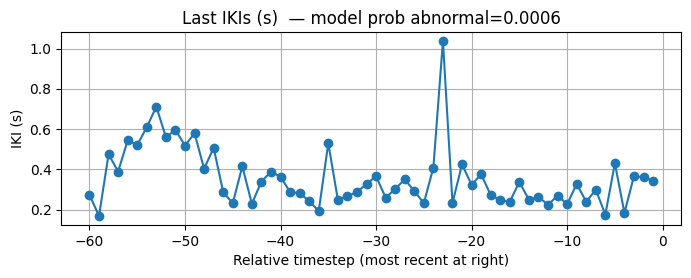

In [15]:
# Robust pairing, inspect df, and run prediction (copy-paste and run in Colab)
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

def events_to_pairs_fixed(events):
    """
    Pair down/up events robustly by order (stack of unmatched downs).
    Returns list of strokes: {'down':..., 'up':..., 'key':...}
    Works fine when all keys are masked as 'KEY'.
    """
    downs_stack = []   # each item: (down_time, key)
    strokes = []
    for e in events:
        t = e['t']
        typ = e['type']
        key = e.get('key','KEY')
        if typ == 'down':
            # push down with its key (we still keep key for backspace detection)
            downs_stack.append((t, key))
        elif typ == 'up':
            # match this up with the most recent unmatched down (LIFO)
            if downs_stack:
                down_t, down_key = downs_stack.pop()   # pair with last down
                strokes.append({'down': down_t, 'up': t, 'key': down_key})
            else:
                # unmatched up: create a degenerate stroke using up==down
                strokes.append({'down': t, 'up': t, 'key': key})
    # If there are leftover downs without up, create strokes with up==down
    while downs_stack:
        down_t, down_key = downs_stack.pop(0)  # earliest left
        strokes.append({'down': down_t, 'up': down_t, 'key': down_key})
    # sort strokes by down time
    strokes.sort(key=lambda s: s['down'])
    return strokes

# 1) show raw events (first few)
print("KE_EVENTS length:", len(KE_EVENTS))
pprint(KE_EVENTS[:12])

# 2) pair reliably and compute features
strokes_fixed = events_to_pairs_fixed(KE_EVENTS)
print("\nPaired strokes count:", len(strokes_fixed))
if len(strokes_fixed) == 0:
    print("No strokes found. Please press Send after typing (and release keys normally), then run this cell again.")
else:
    # make df using the notebook's compute_features_from_strokes (assumes it's loaded)
    df_fixed = compute_features_from_strokes(strokes_fixed)
    display(df_fixed.tail(20))
    print("\nIKIs (ms) summary:")
    print(df_fixed['iki'].describe().round(2))
    print("Hold times (ms) summary:")
    print(df_fixed['hold'].describe().round(2))
    print("Backspace count:", int(df_fixed['backspace'].sum()))

    # 3) create sequence and predict
    seq = df_to_sequence(df_fixed, seq_len=128)
    print("\nSequence shape (seq_len,features):", seq.shape, "  last IKIs (s):", [round(float(x),3) for x in seq[-12:,0]])
    prob = float(lstm.predict(seq[None,:,:])[0,0])
    print(f"\nAbnormal probability (last window, LSTM model): {prob:.4f}")

    # 4) quick plot of last IKIs
    last_ikis_s = seq[-60:,0]  # last 60 timesteps in seconds
    plt.figure(figsize=(8,2.5))
    plt.plot(np.arange(len(last_ikis_s)) - len(last_ikis_s), last_ikis_s, marker='o')
    plt.title(f"Last IKIs (s)  — model prob abnormal={prob:.4f}")
    plt.xlabel("Relative timestep (most recent at right)")
    plt.ylabel("IKI (s)")
    plt.grid(True)
    plt.show()


### 1. Dataset Shapes

```
Dataset shapes: (1600, 128, 3) (1600,)
Train/Val/Test shapes: (1120, 128, 3) (240, 128, 3) (240, 128, 3)
```

*   `Dataset shapes: (1600, 128, 3) (1600,)`: This tells you the shape of your full dataset `X` and labels `y` after synthetic data generation. `X` has 1600 samples, each a sequence of 128 time steps (or keystrokes), and each time step has 3 features (inter-key interval, hold time, backspace flag). `y` has 1600 corresponding labels (0 for human, 1 for AI-like).
*   `Train/Val/Test shapes: (1120, 128, 3) (240, 128, 3) (240, 128, 3)`: This shows how your dataset was split: 1120 samples for training, 240 for validation (used during training to monitor performance), and 240 for final testing.

### 2. LSTM Model Training and Evaluation

```
Epoch 1/8
... (training progress)
LSTM test: [0.08081114292144775, 0.987500011920929]
```

*   **Epochs**: The model was trained for 8 epochs, meaning it iterated over the entire training dataset 8 times.
*   **`auc` (Area Under the Curve)**: This is a performance metric, especially useful for binary classification. An AUC of 1.0 is perfect, and 0.5 is random. During training, you see `auc` for the training data and `val_auc` for the validation data. The `val_auc` should ideally increase and then stabilize without overfitting.
*   **`loss` (Binary Crossentropy Loss)**: This metric measures how well the model is performing; lower values indicate a better fit. You see `loss` for the training data and `val_loss` for the validation data.
*   **`LSTM test: [0.0808..., 0.9875...]`**: This is the final evaluation of your LSTM model on the unseen test set. The first number (`0.0808...`) is the test loss, and the second (`0.9875...`) is the test AUC. An AUC of nearly 0.99 on the test set indicates excellent performance.

### 3. 1D-CNN Model Training and Evaluation

```
Epoch 1/8
... (training progress)
CNN test: [1.952708225871902e-05, 1.0]
```

*   Similar to the LSTM, this section shows the training progress and final evaluation for the 1D-CNN model. You can see very low loss and an AUC of 1.0 on the validation and test sets, suggesting that this synthetic dataset is quite separable for the CNN model.

### 4. Sample LSTM Predictions

```
Sample LSTM predictions on synthetic test:
p_h (some values): [0.00344611 0.0034318  0.9985879  0.99864024 0.998648  ]
```

*   `p_h` contains the predicted probabilities from your LSTM model for the first 5 samples in your test set (`X_test[:5]`).
*   Since the model classifies between human (label 0) and AI-like (label 1), these probabilities represent the model's confidence that a given sample is AI-like.
    *   Values close to **0** (e.g., `0.0034`) indicate a high probability of being **human-like**.
    *   Values close to **1** (e.g., `0.998`) indicate a high probability of being **AI-like**.
*   In this sample output, the first two predictions are very low (near 0), suggesting the model predicts these as human-like typing. The last three predictions are very high (near 1), suggesting the model predicts these as AI-like typing. This demonstrates the model's ability to distinguish between the two types in your synthetic data.

### 5. Live Usage and Model Saving

```
USAGE: After you've typed in the textarea and clicked Send, run this cell to compute current abnormal probability:
Example: prob, seg = predict_abnormal_from_events(KE_EVENTS, lstm); print(prob)
Saved models keystroke_lstm_model.h5 and keystroke_cnn_model.h5 in the Colab runtime.
```

*   This section provides instructions on how to use the `predict_abnormal_from_events` function with real keystroke data collected from the UI. Once you've typed into the box and clicked 'Send', the `KE_EVENTS` list will be populated, and you can then use this function to get a live prediction.
*   Finally, it confirms that both the `lstm` and `cnn` models have been saved to your Colab runtime as HDF5 files (`.h5`), allowing you to load and use them later without retraining.